# Style Transfer with Deep Neural Networks


In this notebook, we’ll *recreate* a style transfer method that is outlined in the paper, [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) in PyTorch.

In this paper, style transfer uses the features found in the 19-layer VGG Network, which is comprised of a series of convolutional and pooling layers, and a few fully-connected layers. In the image below, the convolutional layers are named by stack and their order in the stack. Conv1_1 is the first convolutional layer that an image is passed through, in the first stack. Conv2_1 is the first convolutional layer in the *second* stack. The deepest convolutional layer in the network is conv5_4.

<img src='notebook_ims/vgg19_convlayers.png' width=80% />

### Separating Style and Content

Style transfer relies on separating the content and style of an image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* objects and their arrangement are similar to that of the **content image**
* style, colors, and textures are similar to that of the **style image**

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='notebook_ims/style_tx_cat.png' width=80% />

In this notebook, we'll use a pre-trained VGG19 Net to extract content or style features from a passed in image. We'll then formalize the idea of content and style _losses_ and use those to iteratively update our target image until we get a result that we want. You are encouraged to use a style and content image of your own and share your work on Twitter with @udacity; we'd love to see what you come up with!

In [28]:
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import backend as K

import numpy as np
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# LOAD IMAGE AND PREPROCESSING

In [11]:
content_image_path = "./test_data/content/janelle.png"
style_image_path = "./test_data/style/magritte.jpg"

In [12]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
    
    image = image.resize((size, size))
    np_image = np.expand_dims(np.asarray(image), axis=0) / 255.0
        
    return np_image

def show_image(content_img, style_img):
    if (len(content_img.shape) > 3):
        content_img = np.squeeze(content_img)
    if (len(style_img.shape) > 3):
        style_img = np.squeeze(style_img)
    
    plt.figure(figsize=(32, 16))
    plt.subplot(141)
    plt.imshow(content_img)
    plt.subplot(142)
    plt.imshow(style_img)
    plt.show()

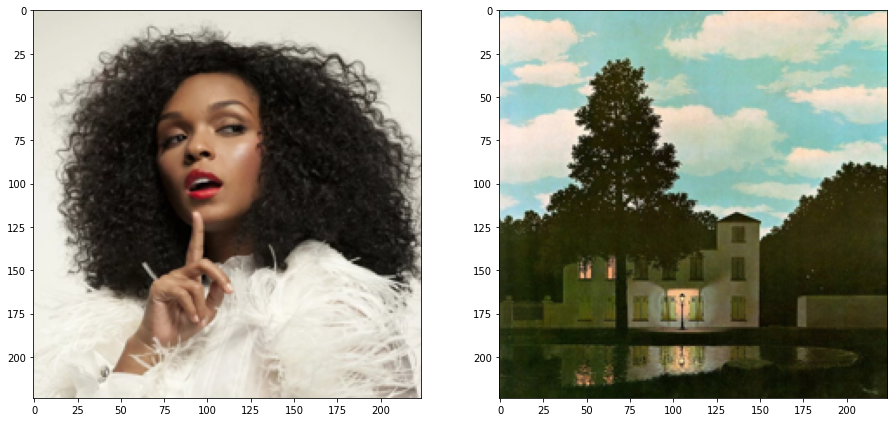

In [13]:
content_image = load_image(content_image_path, shape=224)
style_image = load_image(style_image_path, shape=224)
show_image(content_image, style_image)

# DEFINE MODEL AND TRAINING

### Load pre-trained VGG-16

In [14]:
# Load pre-trained VGG16 feature extractor (not including bottom dense layers) from keras
model = VGG16(weights='imagenet', include_top=False)

# Freeze all the layers because we only train the target image
for layer in model.layers:
    layer.trainable = False

model.summary()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fef82582be0>>
Traceback (most recent call last):
  File "/mnt/g/Projects/study_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/mnt/g/Projects/study_env/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 215626640
Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fef82582b00>>
Traceback (most recent call last):
  File "/mnt/g/Projects/study_env/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/mnt/g

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Instructions for updating:
Use tf.cast instead.


In [26]:
# Layers list to be extracted
layers_list = [1, 2, 5, 9, 13, 17]

### Get output of 5 Convolutional layers

In [73]:
def get_features(image, model, layers_list):
    outputs = [model.layers[layer].output for layer in layers_list]                 # all layer outputs
    functor = K.function([model.input, K.learning_phase()], outputs)   # evaluation function
    layer_outs = functor([content_image, 1.])                          # Testing
    return layer_outs

### Calculate gram-matrix for style 

In [81]:
def gram_matrix(tensor):
    # reshape tensor from (batch_size, w, h, filter) to (batch_size, w*h, filter)
    _, w, h, d = tensor.shape
    tensor = np.reshape((-1, w * h, d))
    return np.einsum('BNi,Bi ->BN', tensor, tensor.transpose())

###